# Big Movers

In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import defaultdict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib import style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]
now = datetime.now(tz=CLIENT_TIMEZONE)
weekday = now.isoweekday()
if weekday > 5:
    now = (now - timedelta(days=weekday - 5)).replace(hour=15)

In [2]:
def get_symbols():
    with open("n13_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [3]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
    
    try:
        page = requests.get(url)
    except Exception as e:
        print("Exception while getiing {}".format(symbol), e)
        return
    else:
        result = page.json()['chart']['result']
        if not result:
            print(symbol, page.json())
            return
        data = result[0]
        quote = data['indicators']['quote'][0]
        if 'timestamp' not in data:
            return
        times = data['timestamp']
        period = data['meta']['currentTradingPeriod']['regular']
        start, end = period['start'], period['end']
        df = pd.Series(quote.get('close'), index=[datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times])
        return df

minute_data = get_minute_data('SRCE', now) # SRCE
minute_data[:10]

2018-05-04 06:30:00-07:00    51.709999
2018-05-04 06:31:00-07:00          NaN
2018-05-04 06:32:00-07:00          NaN
2018-05-04 06:33:00-07:00          NaN
2018-05-04 06:34:00-07:00    50.823601
2018-05-04 06:35:00-07:00          NaN
2018-05-04 06:36:00-07:00          NaN
2018-05-04 06:37:00-07:00          NaN
2018-05-04 06:38:00-07:00          NaN
2018-05-04 06:39:00-07:00          NaN
dtype: float64

In [4]:
def get_period_change(series, period):
    """
    2017-06-02 09:48:00-07:00          NaN
    2017-06-02 09:49:00-07:00    46.834999
    2017-06-02 09:50:00-07:00          NaN
    2017-06-02 09:51:00-07:00          NaN
    2017-06-02 09:52:00-07:00          NaN
    2017-06-02 09:53:00-07:00          NaN
    2017-06-02 09:54:00-07:00          NaN
    2017-06-02 09:55:00-07:00          NaN
    2017-06-02 09:56:00-07:00    46.770000
    """
    start_value = end_value = change = None
    if type(period) is int:
        # get the latest valid value from the previous period
        prev_series = series[:-period]
        li = prev_series.last_valid_index()
        if li:
            start_value = prev_series[li]
            
        period_series = series[-period:]
        li = period_series.last_valid_index()
        if li:
            end_value = period_series[li]
    else:
        fi = series.first_valid_index()
        if fi:
            start_value = series[fi]   
    
        li = series.last_valid_index()
        if li:
            end_value = series[li]
    if None not in (start_value, end_value):
        change = (end_value / start_value - 1) * 100
    return change
    
get_period_change(minute_data, 5)

0.07658609205041245

In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    period_changes = defaultdict(list)
    minute_data = {}    
    symbols_saved = []
    while True:
        try:
            symbol, data = r.get(block=False)
        except queue.Empty:
            break
        else:
            symbols_saved.append(symbol)
            minute_data[symbol] = data
            for p in periods:
                period_changes[p].append(get_period_change(data, p))
                
    period_changes = pd.DataFrame(period_changes, index=symbols_saved)
    
    return period_changes, minute_data

r, e = load_data(("SRCE", "GOOG"), now)
r

,1,5,All day,60,30,15
SRCE,0.15329,0.076586,1.082965,-0.229049,-0.152814,-0.095564


,1,5,15,30,60,All day
0,RUSHB 0.51%,CDXS 1.06%,UBCP 1.12%,UBCP 1.12%,CDXS 1.27%,ENT 6.70%
1,CDXS 0.42%,MBII 0.59%,MBII 0.59%,GLBZ 0.85%,GLBZ 0.85%,CRUS 5.85%
2,PMTS 0.37%,CGBD 0.51%,EARS 0.57%,CDXS 0.84%,GPOR 0.39%,EARS 4.42%
3,CCOI 0.21%,RUSHB 0.51%,CGBD 0.51%,GPOR 0.34%,NWSA 0.34%,CDXS 3.91%
4,CELG 0.17%,ENT 0.42%,CDXS 0.42%,NODK 0.30%,NODK 0.30%,CERS 3.75%
5,GPOR 0.17%,PMTS 0.37%,ENT 0.42%,SRET 0.14%,CELG 0.10%,PLXS 2.97%
6,EXTR 0.14%,CELG 0.30%,NODK 0.30%,NWSA 0.12%,SRET 0.06%,LMAT 2.46%
7,XCRA 0.08%,GPOR 0.28%,LMAT 0.18%,LMAT 0.06%,RUSHB 0.00%,CTHR 2.05%
8,CRUS 0.08%,LMAT 0.21%,TCBK 0.16%,CELG 0.05%,CTHR 0.00%,NODK 2.04%
9,NWSA 0.06%,TCBK 0.19%,SRET 0.14%,XCRA 0.00%,MBII -0.06%,NWLI 2.02%


,1,5,15,30,60,All day
0,EARS -3.28%,EARS -2.25%,FFNW -0.85%,EARS -7.33%,EARS -8.29%,PMTS -2.14%
1,FFNW -0.85%,FFNW -0.85%,DMRC -0.54%,PMTS -1.79%,PMTS -1.79%,ZYNE -1.54%
2,MBII -0.58%,NWLI -0.84%,CERS -0.54%,EVK -1.35%,ZYNE -1.54%,EVK -1.35%
3,NWLI -0.47%,DMRC -0.36%,FNBG -0.47%,ZYNE -0.97%,EVK -1.35%,XCRA -1.26%
4,CERS -0.18%,ZYNE -0.29%,DSPG -0.41%,FNBG -0.91%,FBNK -1.16%,FNBG -0.33%
5,ZYNE -0.10%,DSPG -0.21%,FBNK -0.39%,FFNW -0.85%,FNBG -0.91%,CELG -0.23%
6,PLXS -0.05%,FBNK -0.20%,QLYS -0.27%,TCBK -0.45%,CERS -0.90%,LCA 0.00%
7,CGBD 0.00%,PLXS -0.05%,NWLI -0.20%,ENT -0.42%,FFNW -0.85%,UBCP 0.00%
8,DMRC 0.00%,QLYS -0.03%,ZYNE -0.20%,DSPG -0.41%,TCBK -0.72%,TCBK 0.22%
9,QLYS 0.00%,CRUS -0.03%,PLXS -0.15%,FBNK -0.39%,DMRC -0.54%,FFNW 0.36%


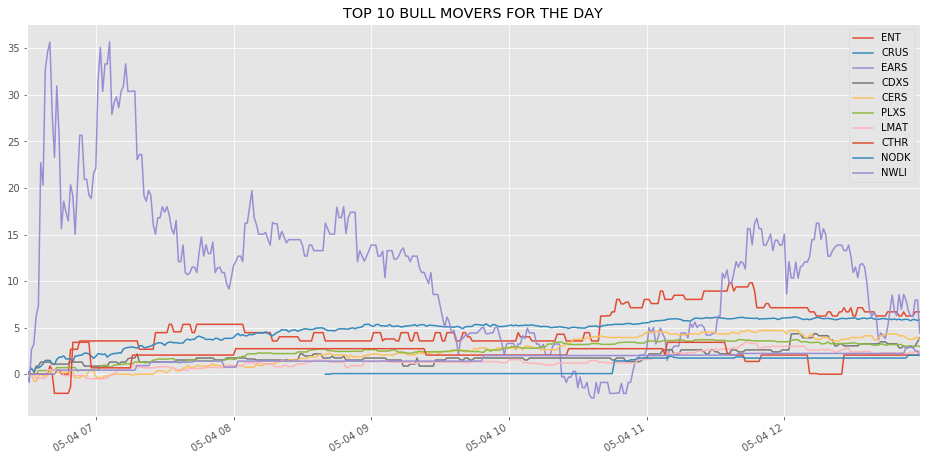

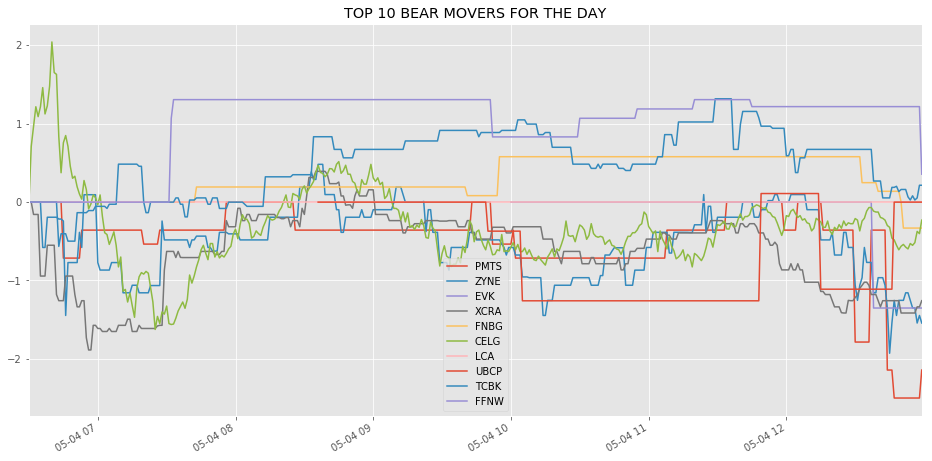

period 0:00:01.849097


KeyboardInterrupt: 

In [7]:
prev_time = None

while True:
    start = datetime.now()
    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    period_changes, minute_data = load_data(symbols, now)
    
    # calc bull&bear moves
    bull = {}
    bear = {}
    top_bull_movers = []
    top_bear_movers = []
    for p in periods:
        changes_bear = period_changes.sort_values(by=p)[:TOP_ITEMS_COUNT]        
        bear[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bear[[p]].itertuples()]       
         
        
        changes_bull = period_changes.sort_values(by=p, ascending=False)[:TOP_ITEMS_COUNT]         
        bull[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bull[[p]].itertuples()]
        
        if p == "All day":
            top_bear_movers = changes_bear.index.values
            top_bull_movers = changes_bull.index.values
    
    # create a table with accumulated changes percents
    changes = None
    for symbol in set(list(top_bull_movers) + list(top_bear_movers)):
        values = minute_data[symbol]
        first_v = next((v for v in values if not isnan(v)), None)
        if first_v:  
            # calculate cumulative changes
            changes_list = []
            prev_change = None
            for v in values:
                change = prev_change if isnan(v) else (v / first_v - 1) * 100
                changes_list.append(change)
                prev_change = change

            # push the changes to the table
            change_df = pd.DataFrame({symbol: changes_list}, values.index)
            if changes is None:
                changes = change_df
            else:
                changes = changes.join(change_df, how="outer")
            
    # display
    clear_output()
    
    display(HTML("<h4>Bull Movers</h4>"))
    bull = pd.DataFrame(bull)
    display(bull[periods]) 
    
    display(HTML("<h4>Bear Movers</h4>"))
    bear = pd.DataFrame(bear)
    display(bear[periods]) 
    
    if changes is not None:        
        changes[top_bull_movers].plot(figsize=(16, 8), title="TOP 10 BULL MOVERS FOR THE DAY")    
        changes[top_bear_movers].plot(figsize=(16, 8), title="TOP 10 BEAR MOVERS FOR THE DAY") 
        plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start